Import Required Libraries

In [9]:
# Import required libraries
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import zipfile
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings



File Paths and Utility Functions

In [10]:
# File paths
FAKE_PATH = '/content/Fake.csv (1).zip'
TRUE_PATH = '/content/True.csv.zip'

def extract_and_load(path, label):
    """Extract CSV from ZIP and load with label"""
    with zipfile.ZipFile(path, 'r') as z:
        csv_file = [f for f in z.namelist() if f.endswith('.csv')][0]
        with z.open(csv_file) as f:
            df = pd.read_csv(f)
            df['label'] = label
    return df

def preprocess_text(text):
    """Enhanced text cleaning"""
    text = str(text).lower()
    # Remove special patterns
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URLs
    text = re.sub(r'\S*@\S*\s?', '', text)  # Emails
    text = re.sub(r'\[.*?\]', '', text)  # Brackets
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)  # Numbers

    # NLP processing
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in text.split()
              if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)


 Load Data

In [11]:
# 1. Load data
print("🔄 Loading datasets...")
try:
    fake_df = extract_and_load(FAKE_PATH, label=0)
    true_df = extract_and_load(TRUE_PATH, label=1)
    df = pd.concat([fake_df, true_df]).sample(frac=1, random_state=42)
    print(f"✅ Loaded {len(df)} samples (Fake: {len(fake_df)}, Real: {len(true_df)})")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    exit()



🔄 Loading datasets...
✅ Loaded 44898 samples (Fake: 23481, Real: 21417)


Preprocessing

In [12]:
# 2. Preprocess with progress bar
print("🧹 Preprocessing text...")
tqdm.pandas()
df['clean_text'] = df['text'].progress_apply(preprocess_text)


🧹 Preprocessing text...


100%|██████████| 44898/44898 [01:32<00:00, 487.38it/s]


Train/Test Split and Model Training

In [13]:
# 3. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# 4. Model Pipeline
print("🤖 Training model...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        stop_words='english',
        sublinear_tf=True)),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        C=0.5,
        solver='liblinear'))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


🤖 Training model...


Evaluation

In [17]:
# 5. Evaluation
print("\n📊 === Final Evaluation ===")
print(f"🔢 Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))


📊 === Final Evaluation ===
🔢 Accuracy: 98.76%
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Feature Importance

In [15]:
# 6. Feature Importance
feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
coefs = pipeline.named_steps['clf'].coef_[0]
print("\n🔝 Top Fake Indicators:", [feature_names[i] for i in coefs.argsort()[:10]])
print("🔝 Top Real Indicators:", [feature_names[i] for i in coefs.argsort()[-10:]])



🔝 Top Fake Indicators: ['image', 'obama', 'president trump', 'gop', 'america', 'american', 'like', 'president obama', 'hillary', 'know']
🔝 Top Real Indicators: ['friday', 'thursday', 'don', 'washington', 'tuesday', 'wednesday', 'president donald', 'washington reuters', 'said', 'reuters']


Word Cloud Visualization


🎨 Generating word clouds...


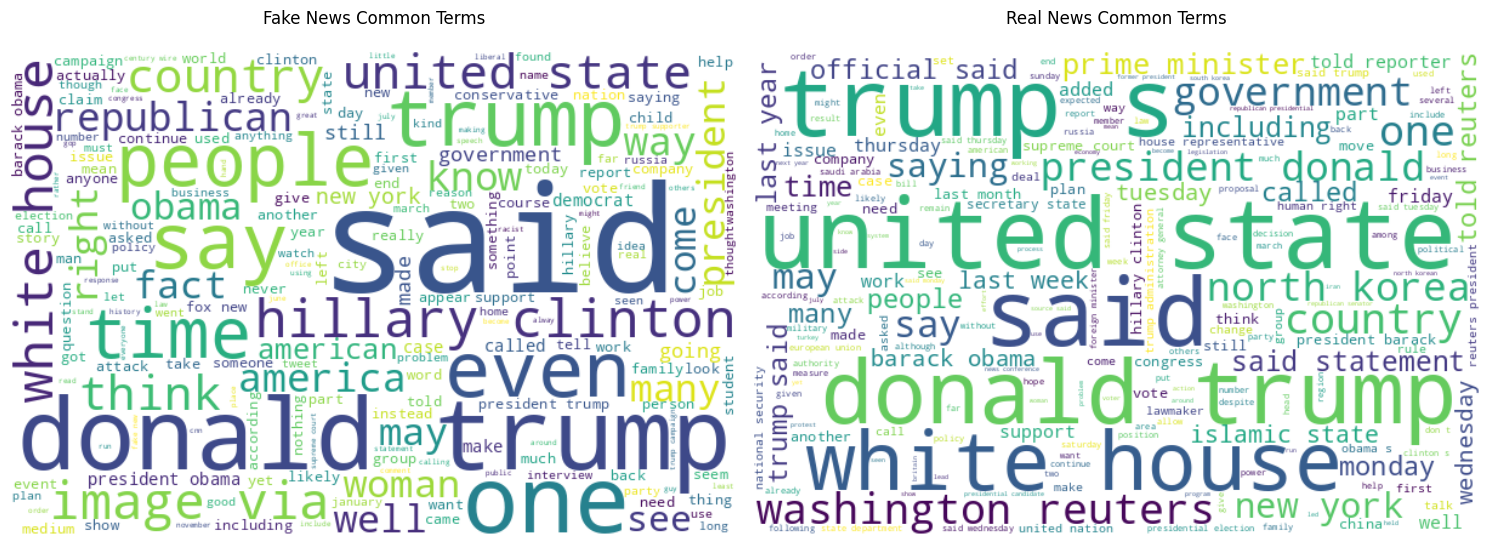


✨ Analysis complete!


In [16]:
# 7. Word Clouds
print("\n🎨 Generating word clouds...")
plt.figure(figsize=(15, 7))

# Fake News Word Cloud
plt.subplot(1, 2, 1)
fake_text = ' '.join(df[df['label'] == 0]['clean_text'])
wc_fake = WordCloud(width=600, height=400,
                   background_color='white',
                   max_words=200).generate(fake_text)
plt.imshow(wc_fake, interpolation='bilinear')
plt.title('Fake News Common Terms', pad=20)
plt.axis('off')

# Real News Word Cloud
plt.subplot(1, 2, 2)
real_text = ' '.join(df[df['label'] == 1]['clean_text'])
wc_real = WordCloud(width=600, height=400,
                   background_color='white',
                   max_words=200).generate(real_text)
plt.imshow(wc_real, interpolation='bilinear')
plt.title('Real News Common Terms', pad=20)
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n✨ Analysis complete!")
